In [41]:
import pandas as pd
import sklearn
import numpy as np
import os
import re
import seaborn as sns

In [12]:
DATASET_FOLDER = '../dataset/'
train = pd.read_csv(os.path.join(DATASET_FOLDER, "train.csv"))
test = pd.read_csv(os.path.join(DATASET_FOLDER, "test.csv"))

In [7]:
train.head()

,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


In [21]:
train["image_link"][74999]

'https://m.media-amazon.com/images/I/81dFnrP6C4L.jpg'

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_id        75000 non-null  int64  
 1   catalog_content  75000 non-null  object 
 2   image_link       75000 non-null  object 
 3   price            75000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB


In [14]:
train.isnull().sum()

sample_id          0
catalog_content    0
image_link         0
price              0
dtype: int64

In [18]:
train["price"].describe()

count    75000.000000
mean        23.647654
std         33.376932
min          0.130000
25%          6.795000
50%         14.000000
75%         28.625000
max       2796.000000
Name: price, dtype: float64

<Axes: xlabel='price', ylabel='Count'>

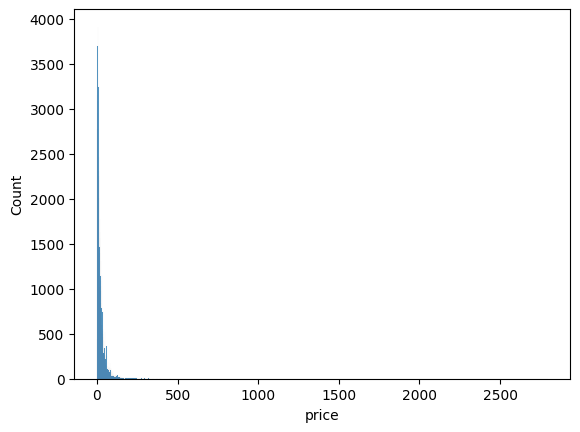

In [32]:
sns.histplot(train["price"])

In [45]:
print(train['catalog_content'][3])

Item Name: Judee’s Blue Cheese Powder 11.25 oz - Gluten-Free and Nut-Free - Use in Seasonings and Salad Dressings - Great for Dips, Spreads and Sauces - Made in USA
Bullet Point 1: Add to your favorite appetizers, dips & spreads. Use to season popcorn or warmed pita chips.
Bullet Point 2: Sprinkle over french fries, fried chicken, mashed potatoes, roasted veggies, pasta, and more
Bullet Point 3: Made in a dedicated gluten-free facility and shipped in a standup, resealable pouch to ensure freshness
Bullet Point 4: Ingredients: Blue Cheese (Milk, Salt, Cultures, & Enzymes) and Disodium Phosphate
Bullet Point 5: Since 2009, Judee’s has been dedicated to providing fresh, allergy-conscious ingredients, great for your recipes and even better for your family
Product Description: Judees Powdered Blue Cheese cheddar cheese powder is an alternative to mozzarella cheese shredded or american cheese slices deli. Make your own alfredo sauce with heavy cream and black buffalo dip with this powder. It

In [50]:
# Assuming 'train' DataFrame is loaded
# train = pd.read_csv('dataset/train.csv') 

def parse_catalog_content(train):
    """
    Parses structured fields (Value, Unit, Item Name) from catalog_content 
    and extracts simple text lengths.
    """
    
    # 1. IPQ/Value and Unit Extraction
    def extract_value_unit(text):
        # Look for Value: X and Unit: Y at the end of the text
        
        # Regex to capture the float value after 'Value:'
        value_match = re.search(r'Value:\s*([\d\.]+)', text, re.IGNORECASE)
        # Regex to capture the unit text after 'Unit:'
        unit_match = re.search(r'Unit:\s*([A-Za-z\s\-\(\)\/\d]+)', text, re.IGNORECASE)
        
        value = float(value_match.group(1)) if value_match else np.nan
        unit = unit_match.group(1).strip() if unit_match else ""
        
        return value, unit
    
    # Apply extraction and assign to new columns
    train[['parsed_value', 'unit']] = train['catalog_content'].apply(
        lambda x: pd.Series(extract_value_unit(x))
    )
    
    # Rename 'parsed_value' to 'ipq' for consistency, as it represents the item quantity/size
    train.rename(columns={'parsed_value': 'ipq'}, inplace=True)

    # 2. Text Length Features (using Item Name as "Title")
    def extract_item_name(text):
        # Find the content after "Item Name:" until the next section start
        match = re.search(r'Item Name:\s*(.*?)(Bullet Point|\n|$)', text, re.DOTALL)
        return match.group(1).strip() if match else ""

    train['item_name'] = train['catalog_content'].apply(extract_item_name)
    train['title_len'] = train['item_name'].apply(lambda x: len(x.split()))
    train['total_len'] = train['catalog_content'].apply(lambda x: len(x.split()))

    # 3. Handle NaN and Log Transformation
    # Fill missing IPQ with 1 (the likely default)
    train['ipq'] = train['ipq'].fillna(1.0)

    #log tranformation
    train['ipq_log'] = np.log1p(train['ipq'])
    train['title_len_log'] = np.log1p(train['title_len'])
    train['total_len_log'] = np.log1p(train['total_len'])

    
    print("✅ Structural features extracted and log-transformed.")
    return train

# # Example Usage:
structural_train = parse_catalog_content(train.copy())
print(structural_train.head())
print(structural_train['unit'].value_counts()) # Check the top units for encoding

✅ Structural features extracted and log-transformed.
   sample_id                                    catalog_content  \
0      33127  Item Name: La Victoria Green Taco Sauce Mild, ...   
1     198967  Item Name: Salerno Cookies, The Original Butte...   
2     261251  Item Name: Bear Creek Hearty Soup Bowl, Creamy...   
3      55858  Item Name: Judee’s Blue Cheese Powder 11.25 oz...   
4     292686  Item Name: kedem Sherry Cooking Wine, 12.7 Oun...   

                                          image_link  price    ipq   unit  \
0  https://m.media-amazon.com/images/I/51mo8htwTH...   4.89  72.00  Fl Oz   
1  https://m.media-amazon.com/images/I/71YtriIHAA...  13.12  32.00  Ounce   
2  https://m.media-amazon.com/images/I/51+PFEe-w-...   1.97  11.40  Ounce   
3  https://m.media-amazon.com/images/I/41mu0HAToD...  30.34  11.25  Ounce   
4  https://m.media-amazon.com/images/I/41sA037+Qv...  66.49  12.00  Count   

                                           item_name  title_len  total_len  \
0  

In [64]:
print(structural_train["unit"].value_counts())

unit
Ounce       40982
Count       17452
Fl Oz       11082
ounce        1960
oz            962
            ...  
PACK            1
can             1
Carton          1
Tea bags        1
7               1
Name: count, Length: 98, dtype: int64


<Axes: xlabel='ipq_log', ylabel='Count'>

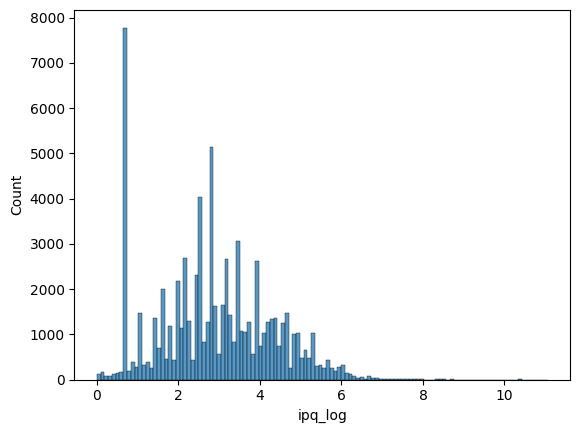

In [52]:
sns.histplot(structural_train["ipq_log"])

In [ ]:
import pandas as pd
import numpy as np

# Assuming structural_train is the DataFrame output from parse_catalog_content
# with columns: ['sample_id', 'ipq_log', 'title_len_log', 'total_len_log', 'unit']

def standardize_and_encode_units(structural_df, top_n=10):
    """
    Cleans, standardizes, and One-Hot Encodes the 'unit' feature.
    """
    df = structural_df.copy()
    
    # 1. Cleaning and Standardization Mapping
    unit_map = {
        # Ounces (Weight/Fluid)
        'ounce': 'Ounce', 'oz': 'Ounce', 'Ounces': 'Ounce', 'Oz': 'Ounce', 'OZ': 'Ounce', 'ounces': 'Ounce',
        'fl oz': 'FluidOunce', 'Fl Oz': 'FluidOunce', 'FL Oz': 'FluidOunce', 'Fluid Ounce': 'FluidOunce',
        'fluid ounces': 'FluidOunce', 'fluid ounce': 'FluidOunce', 'Fl Ounce': 'FluidOunce', 'FL OZ': 'FluidOunce',
        'fluid ounce(s)': 'FluidOunce', 'Fluid Ounces': 'FluidOunce', 'Fluid ounce': 'FluidOunce', 'fl': 'FluidOunce',
        'Fl': 'FluidOunce',
        
        # Count/Pieces
        'count': 'Count', 'ct': 'Count', 'COUNT': 'Count', 'CT': 'Count', 'each': 'Count', 'Each': 'Count',
        'Piece': 'Count', 'units': 'Count', 'unit': 'Count', 'Each / Pack': 'Count', 'capsule': 'Count',
        'product': 'Count', 'Tea Bags': 'Count', 'Tea bags': 'Count', 'K-Cups': 'Count',
        
        # Weight (Non-Ounce)
        'pound': 'Pound', 'lb': 'Pound', 'Pound': 'Pound', 'pounds': 'Pound', 'Pounds': 'Pound', 'kg': 'Kilogram',
        'gram': 'Gram', 'grams': 'Gram', 'Gram': 'Gram', 'gr': 'Gram', 'Grams(gm)': 'Gram', 'gramm': 'Gram',
        
        # Volume (Non-Ounce)
        'milliliter': 'Milliliter', 'millilitre': 'Milliliter', 'ml': 'Milliliter', 'mililitro': 'Milliliter',
        'Liters': 'Liter', 'ltr': 'Liter',
        
        # Packaging
        'pack': 'Pack', 'packs': 'Pack', 'Pack': 'Pack', 'Packs': 'Pack', 'Bag': 'Package', 'bag': 'Package',
        'box': 'Package', 'Box': 'Package', 'Bottle': 'Package', 'bottle': 'Package', 'Carton': 'Package',
        'Can': 'Package', 'can': 'Package', 'Jar': 'Package', 'Pouch': 'Package', 'Bucket': 'Package', 
        'per Box': 'Package', 'Per Package': 'Package', 'per Carton': 'Package', 'BOX/12': 'Package',
        '1 PK': 'Package', 'CASE\nBullet Point 2': 'Package',
        
        # Other/Irrelevant/Special
        'in': 'Other', 'sq ft': 'Other', 'Sq Ft': 'Other', 'Foot': 'Other', 'cm/inch)': 'Other',
        '2': 'Other', '8': 'Other', '24': 'Other', '7': 'Other', '1': 'Other', '20 oz': 'Other',
        '---': 'Other', '-': 'Other', 'None': 'Other', '': 'Other', 'Comes as a single 0': 'Other', 
        'Paper Cupcake Liners': 'Other', 'Ziplock bags': 'Other'
    }

    # Standardize the unit column
    df['unit_standardized'] = df['unit'].str.strip().replace(unit_map).str.title().fillna('Other')

    # Assign all unmapped values to 'Other'
    df.loc[~df['unit_standardized'].isin(unit_map.values()), 'unit_standardized'] = 'Other'
    
    # 2. Select Top N and Encode
    top_units = df['unit_standardized'].value_counts().nlargest(top_n).index.tolist()
    
    # Create the final unit column for encoding (assigning non-top units to 'Other')
    df['unit_final'] = df['unit_standardized'].apply(
        lambda x: x if x in top_units else 'Other'
    )
    
    # One-Hot Encode the final unit column
    unit_encoded_df = pd.get_dummies(df['unit_final'], prefix='unit')
    
    # Concatenate the new one-hot features with the structural data
    final_structural_df = pd.concat([df.drop(columns=['unit', 'unit_standardized','item_name']), unit_encoded_df], axis=1)
    
    print(f"✅ Units standardized and One-Hot Encoded. Total unit features: {unit_encoded_df.shape[1]}") 
    print(unit_encoded_df.shape)
    return final_structural_df

# Example Usage:
final_train = standardize_and_encode_units(structural_train)
print(final_train.head())
print(final_train.shape)

✅ Units standardized and One-Hot Encoded. Total unit features: 10
(75000, 10)
   sample_id                                    catalog_content  \
0      33127  Item Name: La Victoria Green Taco Sauce Mild, ...   
1     198967  Item Name: Salerno Cookies, The Original Butte...   
2     261251  Item Name: Bear Creek Hearty Soup Bowl, Creamy...   
3      55858  Item Name: Judee’s Blue Cheese Powder 11.25 oz...   
4     292686  Item Name: kedem Sherry Cooking Wine, 12.7 Oun...   

                                          image_link  price    ipq  title_len  \
0  https://m.media-amazon.com/images/I/51mo8htwTH...   4.89  72.00         11   
1  https://m.media-amazon.com/images/I/71YtriIHAA...  13.12  32.00         11   
2  https://m.media-amazon.com/images/I/51+PFEe-w-...   1.97  11.40         14   
3  https://m.media-amazon.com/images/I/41mu0HAToD...  30.34  11.25         28   
4  https://m.media-amazon.com/images/I/41sA037+Qv...  66.49  12.00         10   

   total_len   ipq_log  title_le

##### They are 10 unique units

In [60]:
final_train["unit_final"].value_counts()

unit_final
Ounce         44026
Count         18297
Other         12300
Pound           236
Gram             51
Package          40
Pack             21
Milliliter       15
Liter             8
Kilogram          6
Name: count, dtype: int64

In [71]:
final_train.to_csv('preprocessed_data.csv', index=False)
final_train.to_csv('Delete_preprocessed_data.csv', index=True)

#### Saved till here

In [1]:
import pandas as pd
train_import = pd.read_csv("preprocessed_data.csv")
train_import.head()

,sample_id,catalog_content,image_link,price,ipq,title_len,total_len,ipq_log,title_len_log,total_len_log,...,unit_Count,unit_Gram,unit_Kilogram,unit_Liter,unit_Milliliter,unit_Other,unit_Ounce,unit_Pack,unit_Package,unit_Pound
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89,72.00,11,18,4.290459,2.484907,2.944439,...,False,False,False,False,False,True,False,False,False,False
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12,32.00,11,80,3.496508,2.484907,4.394449,...,False,False,False,False,False,False,True,False,False,False
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97,11.40,14,59,2.517696,2.708050,4.094345,...,False,False,False,False,False,False,True,False,False,False
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34,11.25,28,211,2.505526,3.367296,5.356586,...,False,False,False,False,False,False,True,False,False,False
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49,12.00,10,28,2.564949,2.397895,3.367296,...,True,False,False,False,False,False,False,False,False,False


In [3]:
train_import['image_link'].value_counts().sum()

np.int64(75000)

In [4]:
train_import['image_link'].unique()

array(['https://m.media-amazon.com/images/I/51mo8htwTHL.jpg',
       'https://m.media-amazon.com/images/I/71YtriIHAAL.jpg',
       'https://m.media-amazon.com/images/I/51+PFEe-w-L.jpg', ...,
       'https://m.media-amazon.com/images/I/91R2XCcpUfL.jpg',
       'https://m.media-amazon.com/images/I/51W40YU98+L.jpg',
       'https://m.media-amazon.com/images/I/81dFnrP6C4L.jpg'],
      shape=(72288,), dtype=object)

In [9]:
print(train_import[train_import['sample_id'] == 279285]['image_link'])

38945    https://m.media-amazon.com/images/I/51mjZYDYjy...
Name: image_link, dtype: object


In [10]:
import pandas as pd

# Display all rows
pd.set_option('display.max_rows', None) 

# Display all columns
pd.set_option('display.max_columns', None)

# Display full column content (no truncation within cells)
pd.set_option('display.max_colwidth', None)

# Set the width of the display window (useful for wide dataframes)
pd.set_option('display.width', 1000) 

In [11]:
print(train_import[train_import['sample_id'] == 279285]['image_link'])

38945    https://m.media-amazon.com/images/I/51mjZYDYjyL.jpg
Name: image_link, dtype: object


In [12]:
from utils import download_image
download_image(" https://m.media-amazon.com/images/I/51mjZYDYjyL.jpg", "src")

HTTP Error 404: Not Found
